In [ ]:
# LEXICON & CORPUS ABOVE
# MODEL BELOW

In [ ]:
# ============================================================================
# STEP 1: PACKAGE INSTALLATION (Run this first, then restart kernel)
# ============================================================================
# This cell installs all required Python packages for model training

import subprocess
import sys

packages = [
    'numpy',
    'pandas',
    'scikit-learn',
    'matplotlib',
    'seaborn',
    'openpyxl',
    'nltk',
    'tqdm',
    'torch --index-url https://download.pytorch.org/whl/cpu',
    'transformers',
    'sentencepiece',
    'accelerate',
    'datasets',
    'lime',
    'scipy'
]

for package in packages:
    print(f"\nInstalling {package.split()[0]}...")
    try:
        result = subprocess.run(
            [sys.executable, '-m', 'pip', 'install'] + package.split(),
            capture_output=True,
            text=True,
            timeout=300
        )
        if result.returncode == 0:
            print(f"{package.split()[0]} installed")
        else:
            print(f"{package.split()[0]} had issues")
    except Exception as e:
        print(f"Error: {str(e)[:100]}")


Installing numpy...
numpy installed

Installing pandas...
numpy installed

Installing pandas...
pandas installed

Installing scikit-learn...
pandas installed

Installing scikit-learn...
scikit-learn installed

Installing matplotlib...
scikit-learn installed

Installing matplotlib...
matplotlib installed

Installing seaborn...
matplotlib installed

Installing seaborn...
seaborn installed

Installing openpyxl...
seaborn installed

Installing openpyxl...
openpyxl installed

Installing nltk...
openpyxl installed

Installing nltk...
nltk installed

Installing tqdm...
nltk installed

Installing tqdm...
tqdm installed

Installing torch...
tqdm installed

Installing torch...
torch installed

Installing transformers...
torch installed

Installing transformers...
transformers installed

Installing sentencepiece...
transformers installed

Installing sentencepiece...
sentencepiece installed

Installing accelerate...
sentencepiece installed

Installing accelerate...
accelerate installed

Installin

In [1]:
# ============================================================================
# STEP 2: ALL IMPORTS (Run after restarting kernel)
# ============================================================================
# Import all necessary libraries for the project
# - pandas/numpy: data manipulation
# - matplotlib/seaborn: visualizations
# - torch: PyTorch deep learning framework
# - transformers: Hugging Face library for pre-trained models
# - sklearn: machine learning metrics
# - lime: explainable AI
# - tqdm: progress bars

import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    precision_score, 
    recall_score,
    classification_report, 
    confusion_matrix
)
from scipy import stats
import transformers
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    Trainer, 
    TrainingArguments,
    TrainerCallback
)
from lime.lime_text import LimeTextExplainer
from tqdm.auto import tqdm

print("Libraries imported successfully.")

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Libraries imported successfully.
Libraries imported successfully.


In [3]:
# ============================================================================
# STEP 3: LOAD MULTILINGUAL CORPUS DATA
# ============================================================================
# Load the enhanced corpus file that contains:
# - Source and target language texts
# - Sentiment labels (negative/neutral/positive)
# - Word-level sentiment scores
# - VADER sentiment analysis scores
# - Confidence weights for training

# Use the enhanced corpus created in LexiconTeam notebook
data_dir = "C:/Users/User/Desktop/Assignment 3/Code/INF-791-Assignment3/"
corpus_df = pd.read_csv(data_dir + "multilingual_corpus_enhanced_final.csv")

print(f"Total corpus rows: {len(corpus_df)}")
print(f"Columns: {corpus_df.columns.tolist()}")
print(f"\nLanguages in corpus:")
print(corpus_df['target_language'].value_counts())

# Create a list to store all high-quality multilingual sentences
multilingual_data = []

# Strategy: Use the enhanced corpus which already has:
# - High-quality translations
# - Word-level sentiment scores
# - VADER sentiment analysis
# - Confidence weights

print("\n" + "="*60)
print("BUILDING MULTILINGUAL DATASET FROM ENHANCED CORPUS")
print("="*60)

# ============================================================================
# PROCESS ALL SENTENCES (Source and Target Languages)
# ============================================================================
print(f"\nProcessing {len(corpus_df)} high-quality sentences...")

processed_count = 0
filtered_count = 0

# Loop through each sentence in the enhanced corpus
for _, row in corpus_df.iterrows():
    text = row['translated_text']  # Use translated text for all languages
    
    # Map sentiment labels from VADER sentiment or custom sentiment
    # Priority: vader_sentiment if available and confident, else use sentiment_v2
    if pd.notna(row.get('vader_sentiment')) and abs(row.get('vader_compound', 0)) > 0.3:
        sentiment = row['vader_sentiment']
    else:
        sentiment = row.get('sentiment_v2', row.get('sentiment_avg', 'neutral'))
    
    # Quality filter: Remove sentences that are too short or empty
    if pd.isna(text) or len(str(text).strip()) < 5:
        filtered_count += 1
        continue
    
    # Add the sentence to our dataset
    multilingual_data.append({
        'text': str(text),
        'sentiment': sentiment,
        'language': row['target_language'],
        'vader_compound': row['vader_compound'],
        'confidence': abs(row['vader_compound'])  # Absolute VADER compound as confidence
    })
    processed_count += 1

print(f"Added {processed_count} sentences (filtered {filtered_count} low-quality)")

# ============================================================================
# CREATE DATAFRAME AND ANALYZE THE DATASET
# ============================================================================
all_data_df = pd.DataFrame(multilingual_data)
print(f"\n{'='*60}")
print(f"TOTAL DATASET: {len(all_data_df)} high-quality multilingual samples")
print(f"\nLanguage distribution:")
print(all_data_df['language'].value_counts())
print(f"\nSentiment distribution:")
print(all_data_df['sentiment'].value_counts())
print(f"\nAverage confidence per language:")
print(all_data_df.groupby('language')['confidence'].mean().round(3))

# ============================================================================
# STEP 4: Split data into training and test sets
# ============================================================================
# Use stratified splitting to ensure all languages and sentiments
# are represented in both train and test sets
from sklearn.model_selection import train_test_split

# Create a combined key for stratification: "sentiment_language"
# This ensures balanced representation of each sentiment-language pair
all_data_df['strat_key'] = all_data_df['sentiment'] + '_' + all_data_df['language']

# Remove rare combinations (less than 2 samples) to avoid stratification errors
strat_counts = all_data_df['strat_key'].value_counts()
valid_keys = strat_counts[strat_counts >= 2].index
all_data_df = all_data_df[all_data_df['strat_key'].isin(valid_keys)].copy()

print(f"\nAfter filtering rare combinations: {len(all_data_df)} samples")

# Perform the split: 70% training, 30% testing
train_data, test_data = train_test_split(
    all_data_df, 
    test_size=0.3,  # 30% for testing
    random_state=42,  # Fixed seed for reproducibility
    stratify=all_data_df['strat_key']  # Maintain proportions
)

# Clean up temporary columns we don't need anymore
train_data = train_data.drop(columns=['strat_key', 'vader_compound', 'confidence'])
test_data = test_data.drop(columns=['strat_key', 'vader_compound', 'confidence'])

print(f"\n{'='*60}")
print(f"TRAIN SET: {len(train_data)} samples")
print(f"Languages in training:")
print(train_data['language'].value_counts())
print(f"Sentiment distribution:")
print(train_data['sentiment'].value_counts())

print(f"\n{'='*60}")
print(f"TEST SET: {len(test_data)} samples")
print(f"Languages in testing:")
print(test_data['language'].value_counts())
print(f"Sentiment distribution:")
print(test_data['sentiment'].value_counts())

# ============================================================================
# STEP 5: Convert text sentiments to numeric labels
# ============================================================================
# Models need numbers, not text, so we map:
# negative → 0, neutral → 1, positive → 2
sentiment_to_label = {'negative': 0, 'neutral': 1, 'positive': 2}
label_to_sentiment = {0: 'negative', 1: 'neutral', 2: 'positive'}

train_data['label'] = train_data['sentiment'].map(sentiment_to_label)
test_data['label'] = test_data['sentiment'].map(sentiment_to_label)

# Save test set for reproducibility (save to Connor/data/processed if that folder exists)
output_dir = "C:/Users/User/Desktop/Assignment 3/Code/INF-791-Assignment3/Connor/data/processed/"
import os
if not os.path.exists(output_dir):
    output_dir = data_dir  # Fall back to source directory

test_data.to_csv(output_dir + 'plm_multilingual_test_split.csv', index=False)
print(f"\nTest set saved to: {output_dir}plm_multilingual_test_split.csv")

print(f"\n{'='*60}")
print("HIGH-QUALITY MULTILINGUAL DATA READY")
print(f"{'='*60}")

Total corpus rows: 1500
Columns: ['source_language', 'target_language', 'sentence', 'translated_text', 'total_score_avg', 'word_scores_avg', 'sentiment_avg', 'total_score_v2', 'word_scores_v2', 'sentiment_v2', 'vader_positive', 'vader_negative', 'vader_neutral', 'vader_compound', 'vader_sentiment', 'custom_sentiment_numeric', 'vader_sentiment_numeric']

Languages in corpus:
target_language
fr    375
af    375
ts    375
zu    375
Name: count, dtype: int64

BUILDING MULTILINGUAL DATASET FROM ENHANCED CORPUS

Processing 1500 high-quality sentences...
Added 1500 sentences (filtered 0 low-quality)

TOTAL DATASET: 1500 high-quality multilingual samples

Language distribution:
language
fr    375
af    375
ts    375
zu    375
Name: count, dtype: int64

Sentiment distribution:
sentiment
neutral     656
positive    616
negative    228
Name: count, dtype: int64

Average confidence per language:
language
af    0.011
fr    0.035
ts    0.005
zu    0.000
Name: confidence, dtype: float64

After filter

In [ ]:
# ============================================================================
# STEP 4: ADVANCED DATA AUGMENTATION & CONFIDENCE WEIGHTING
# ============================================================================
# This cell implements two advanced techniques:
# 1. Word-level sentiment masking for data augmentation
# 2. Confidence scoring based on VADER sentiment strength

import re
import random

print("="*60)
print("ADVANCED DATA AUGMENTATION")
print("="*60)

# ============================================================================
# Function 1: Parse word-level sentiment scores
# ============================================================================
def parse_word_scores(word_scores_str):
    if pd.isna(word_scores_str):
        return {}
    
    word_dict = {}
    try:
        pairs = str(word_scores_str).split(';')
        for pair in pairs:
            if ':' in pair:
                word, score = pair.strip().split(':')
                word_dict[word.strip().lower()] = float(score)
    except:
        pass
    return word_dict

# ============================================================================
# Function 2: Create augmented samples by masking neutral words
# ============================================================================
def augment_with_word_masking(text, word_scores, mask_prob=0.2):
    words = str(text).split()
    word_score_dict = parse_word_scores(word_scores)
    
    if not word_score_dict:
        return text
    
    augmented_words = []
    for word in words:
        word_lower = word.lower()
        score = word_score_dict.get(word_lower, 0)
        
        # If word has low sentiment (|score| < 1.5), randomly mask it
        if abs(score) < 1.5 and random.random() < mask_prob:
            augmented_words.append('[MASK]')  # Replace with [MASK] token
        else:
            augmented_words.append(word)  # Keep the word
    
    return ' '.join(augmented_words)

print("\nAdding confidence scores and word-level features...")

# ============================================================================
# STEP 1: Reload corpus to get word-level scores
# ============================================================================
# Use the enhanced corpus which already has word-level scores
corpus_full = pd.read_csv(data_dir + "multilingual_corpus_enhanced_final.csv")

# Create list to store enhanced samples (original + augmented)
enhanced_data = []

# ============================================================================
# STEP 2: Process each sentence and create augmented versions
# ============================================================================
for _, row in corpus_full.iterrows():
    # Get the translated text (all languages)
    text = row['translated_text']
    
    if pd.isna(text):
        continue
    
    # Determine sentiment - use VADER if confident, else use sentiment_v2
    if pd.notna(row.get('vader_sentiment')) and abs(row.get('vader_compound', 0)) > 0.3:
        sentiment = row['vader_sentiment']
    else:
        sentiment = row.get('sentiment_v2', row.get('sentiment_avg', 'neutral'))
    
    # Add the original sample with confidence score
    base_sample = {
        'text': str(text),
        'sentiment': sentiment,
        'language': row['target_language'],
        'confidence': abs(row['vader_compound']),  # Higher = more confident
        'word_scores': row['word_scores_v2']
    }
    enhanced_data.append(base_sample)
    
    # Data Augmentation: Create additional training samples
    # Only augment high-confidence samples (vader > 0.3) with 30% probability
    if abs(row['vader_compound']) > 0.3 and random.random() < 0.3:
        augmented_text = augment_with_word_masking(text, row['word_scores_v2'])
        
        # Only add if the text actually changed (some words were masked)
        if augmented_text != str(text):
            aug_sample = {
                'text': augmented_text,
                'sentiment': sentiment,
                'language': row['target_language'],
                'confidence': abs(row['vader_compound']) * 0.9,  # Slightly lower confidence
                'word_scores': row['word_scores_v2']
            }
            enhanced_data.append(aug_sample)

# ============================================================================
# STEP 3: Create DataFrame and analyze augmentation results
# ============================================================================
enhanced_df = pd.DataFrame(enhanced_data)

print(f"Original samples: {len(corpus_full)}")
print(f"Enhanced samples (with augmentation): {len(enhanced_df)}")
print(f"Augmentation rate: {(len(enhanced_df) - len(corpus_full)) / len(corpus_full) * 100:.1f}%")

print(f"\nConfidence distribution:")
print(f"Mean: {enhanced_df['confidence'].mean():.3f}")
print(f"Median: {enhanced_df['confidence'].median():.3f}")
print(f"High confidence (>0.5): {(enhanced_df['confidence'] > 0.5).sum()} samples")

# ============================================================================
# STEP 4: Map sentiments to numeric labels
# ============================================================================
sentiment_to_label = {'negative': 0, 'neutral': 1, 'positive': 2}
label_to_sentiment = {0: 'negative', 1: 'neutral', 2: 'positive'}

enhanced_df['label'] = enhanced_df['sentiment'].map(sentiment_to_label)

# ============================================================================
# STEP 5: Split enhanced dataset into train and test
# ============================================================================
# Create stratification key to balance sentiment-language combinations
enhanced_df['strat_key'] = enhanced_df['sentiment'] + '_' + enhanced_df['language']

# Remove rare combinations (< 2 samples)
strat_counts = enhanced_df['strat_key'].value_counts()
valid_keys = strat_counts[strat_counts >= 2].index
enhanced_df_filtered = enhanced_df[enhanced_df['strat_key'].isin(valid_keys)].copy()

# Perform 70/30 split
train_data_enhanced, test_data_enhanced = train_test_split(
    enhanced_df_filtered,
    test_size=0.3,
    random_state=42,
    stratify=enhanced_df_filtered['strat_key']
)

# Prepare final train/test sets
# Train set keeps confidence scores for weighted training
# Test set doesn't need confidence (just used for evaluation)
train_data = train_data_enhanced[['text', 'sentiment', 'language', 'label', 'confidence']].copy()
test_data = test_data_enhanced[['text', 'sentiment', 'language', 'label']].copy()

print(f"\n{'='*60}")
print(f"ENHANCED TRAIN SET: {len(train_data)} samples")
print(f"Languages: {train_data['language'].value_counts().to_dict()}")
print(f"Sentiments: {train_data['sentiment'].value_counts().to_dict()}")

print(f"\n{'='*60}")
print(f"ENHANCED TEST SET: {len(test_data)} samples")
print(f"Languages: {test_data['language'].value_counts().to_dict()}")
print(f"Sentiments: {test_data['sentiment'].value_counts().to_dict()}")

print(f"\n{'='*60}")
print("ENHANCED DATA WITH AUGMENTATION & CONFIDENCE READY")
print(f"{'='*60}")

ADVANCED DATA AUGMENTATION

Adding confidence scores and word-level features...


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/User/Desktop/Assignment 3/Code/INF-791-Assignment3/test_corpus_processed.csv'

In [ ]:
# ============================================================================
# AFRIBERTA MODEL
# ============================================================================

In [ ]:
# ============================================================================
# STEP 5: LOAD AFRIBERTA MODEL
# ============================================================================
# AfriBERTa is a pre-trained language model specifically trained on African languages
# We'll fine-tune it for sentiment classification (negative/neutral/positive)

print("=" * 70)
print("AFRIBERTA MODEL INITIALIZATION")
print("=" * 70)

# Check if GPU is available (faster) or use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# Load the pre-trained AfriBERTa model from Hugging Face
afriberta_model_name = "castorini/afriberta_base"
print(f"\nLoading AfriBERTa from: {afriberta_model_name}")

# Load tokenizer (converts text to numbers the model can understand)
afriberta_tokenizer = AutoTokenizer.from_pretrained(afriberta_model_name)

# Load model and configure it for 3-class sentiment classification
afriberta_model = AutoModelForSequenceClassification.from_pretrained(
    afriberta_model_name,
    num_labels=3,  # 3 sentiment classes
    id2label={0: "negative", 1: "neutral", 2: "positive"},  # Number to label mapping
    label2id={"negative": 0, "neutral": 1, "positive": 2}   # Label to number mapping
)
afriberta_model.to(device)  # Move model to GPU or CPU

print(f"AfriBERTa loaded successfully")
print(f"Model parameters: {sum(p.numel() for p in afriberta_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in afriberta_model.parameters() if p.requires_grad):,}")

AFRIBERTA MODEL INITIALIZATION
💻 Device: cpu

📥 Loading AfriBERTa from: castorini/afriberta_base


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkp

✅ AfriBERTa loaded successfully
   Model parameters: 111,457,539
   Trainable parameters: 111,457,539


In [ ]:
# ============================================================================
# STEP 6: TOKENIZE DATA FOR AFRIBERTA
# ============================================================================
# Convert text to numbers (tokens) that the model can process

def tokenize_data(texts, labels, tokenizer, max_length=128):
    # Tokenize all texts at once
    encodings = tokenizer(
        texts,
        padding="max_length",     # Pad shorter texts to max_length
        truncation=True,          # Cut off texts longer than max_length
        max_length=max_length,    # Maximum 128 tokens per text
        return_tensors="pt"       # Return PyTorch tensors
    )
    
    # Create a PyTorch Dataset class
    class SentimentDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels
            
        def __getitem__(self, idx):
            # Get one sample (tokenized text + label)
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item
            
        def __len__(self):
            return len(self.labels)
    
    return SentimentDataset(encodings, labels)

print("Tokenizing data for AfriBERTa...")

# Prepare training data
afriberta_train_texts = train_data['text'].tolist()
afriberta_train_labels = train_data['label'].tolist()
afriberta_train_dataset = tokenize_data(afriberta_train_texts, afriberta_train_labels, afriberta_tokenizer)

# Prepare test data
afriberta_test_texts = test_data['text'].tolist()
afriberta_test_labels = test_data['label'].tolist()
afriberta_test_dataset = tokenize_data(afriberta_test_texts, afriberta_test_labels, afriberta_tokenizer)

print(f"Tokenization complete")
print(f"Training dataset: {len(afriberta_train_dataset)} samples")
print(f"Test dataset: {len(afriberta_test_dataset)} samples")

🔄 Tokenizing data for AfriBERTa...
✅ Tokenization complete
   Training dataset: 351 samples
   Test dataset: 151 samples


In [ ]:
# ============================================================================
# STEP 7: CUSTOM TRAINER WITH CONFIDENCE WEIGHTING
# ============================================================================
# This custom trainer gives more importance to high-confidence samples
# during training (samples where we're more sure about the sentiment)

from transformers import Trainer
import torch.nn as nn

class ConfidenceWeightedTrainer(Trainer):
    
    def __init__(self, *args, sample_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.sample_weights = sample_weights
        if sample_weights is not None:
            self.sample_weights = sample_weights.to(self.args.device)
        
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Calculate cross-entropy loss for each sample (no averaging yet)
        loss_fct = nn.CrossEntropyLoss(reduction='none')
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        
        # Apply confidence weights if available
        if self.sample_weights is not None:
            # Scale the loss by average confidence weight
            weight_scale = self.sample_weights.mean().item()
            loss = loss * weight_scale
        
        # Average the loss across all samples
        loss = loss.mean()
        
        return (loss, outputs) if return_outputs else loss

# ============================================================================
# PREPARE CONFIDENCE WEIGHTS FOR TRAINING
# ============================================================================
# Convert confidence scores to PyTorch tensor
train_confidence_weights = torch.tensor(train_data['confidence'].tolist(), dtype=torch.float32)

# Normalize weights so they average to 1.0 (prevents scaling issues)
train_confidence_weights = train_confidence_weights / train_confidence_weights.mean()

print("Confidence-Weighted Training Setup")
print(f"Weight range: {train_confidence_weights.min():.3f} - {train_confidence_weights.max():.3f}")
print(f"Weight mean: {train_confidence_weights.mean():.3f}")
print(f"High-weight samples (>1.5): {(train_confidence_weights > 1.5).sum()}")
print(f"Low-weight samples (<0.5): {(train_confidence_weights < 0.5).sum()}")
print("Custom trainer ready with confidence weighting")

🎯 Confidence-Weighted Training Setup
   Weight range: 0.000 - 11.393
   Weight mean: 1.000
   High-weight samples (>1.5): 56
   Low-weight samples (<0.5): 293
✅ Custom trainer ready with confidence weighting


In [ ]:
# ============================================================================
# STEP 8: TRAIN AFRIBERTA MODEL
# ============================================================================

# Define function to calculate evaluation metrics
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)  # Get predicted class (0, 1, or 2)
    
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1_weighted': f1_score(labels, predictions, average='weighted'),
        'f1_macro': f1_score(labels, predictions, average='macro'),
        'precision': precision_score(labels, predictions, average='weighted'),
        'recall': recall_score(labels, predictions, average='weighted')
    }

# Configure training parameters
afriberta_training_args = TrainingArguments(
    output_dir='./results_afriberta',        # Where to save results
    num_train_epochs=3,                      # Train for 3 epochs
    per_device_train_batch_size=8,           # Process 8 samples at a time
    per_device_eval_batch_size=8,            # Evaluate 8 samples at a time
    learning_rate=3e-5,                      # Learning rate (how fast to learn)
    weight_decay=0.01,                       # Regularization to prevent overfitting
    warmup_steps=100,                        # Gradually increase learning rate
    logging_dir='./logs',                    # Save training logs here
    logging_steps=20,                        # Log progress every 20 steps
    save_steps=200,                          # Save checkpoint every 200 steps
    eval_strategy="no",                      # Don't evaluate during training
    save_total_limit=2,                      # Keep only 2 checkpoints
    report_to=None,                          # Don't report to external services
    remove_unused_columns=False,
    load_best_model_at_end=False,
)

# Create trainer with confidence weighting
afriberta_trainer = ConfidenceWeightedTrainer(
    model=afriberta_model,
    args=afriberta_training_args,
    train_dataset=afriberta_train_dataset,
    tokenizer=afriberta_tokenizer,
    compute_metrics=compute_metrics,
    sample_weights=train_confidence_weights  # Use confidence weighting
)

print("=" * 70)
print("TRAINING AFRIBERTA")
print("=" * 70)
print(f"Training samples: {len(afriberta_train_dataset)}")
print(f"Epochs: {afriberta_training_args.num_train_epochs}")
print(f"Batch size: {afriberta_training_args.per_device_train_batch_size}")
print(f"Learning rate: {afriberta_training_args.learning_rate}")

# Start training
print("\nStarting training...")
afriberta_training_results = afriberta_trainer.train()

# Save the trained model and tokenizer
afriberta_trainer.save_model('./models/afriberta-sentiment')
afriberta_tokenizer.save_pretrained('./models/afriberta-sentiment')

print("\nAfriBERTa training completed!")
print(f"Training loss: {afriberta_training_results.metrics['train_loss']:.4f}")
print(f"Model saved to: ./models/afriberta-sentiment")

C:\Users\User\AppData\Local\Temp\ipykernel_17296\1955003687.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `ConfidenceWeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


TRAINING AFRIBERTA
Training samples: 351
Epochs: 3
Batch size: 8
Learning rate: 3e-05

🚀 Starting training...


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\User\AppData\Local\Temp\ipykernel_17296\1325248023.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
20,0.787100
40,0.357500
60,0.240400
80,0.283500
100,0.251900
120,0.139400


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\configuration_utils.py:461: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\configuration_utils.py:461: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will becom


✅ AfriBERTa training completed!
   Training loss: 0.3405
   Model saved to: ./models/afriberta-sentiment


AFRIBERTA EVALUATION

🔍 Evaluating on test set...


Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\User\AppData\Local\Temp\ipykernel_17296\1325248023.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\User\AppData\Local\Temp\ipykernel_17296\1325248023.py:18: UserWarning: To copy construct fro

Evaluating: 100%|██████████| 19/19 [00:08<00:00,  2.52it/s]c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divis


📊 AfriBERTa Test Results:
   Accuracy:  0.9470
   Precision: 0.8968
   Recall:    0.9470
   F1 (weighted): 0.9213
   F1 (macro):    0.3243

📋 Detailed Classification Report:
              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000         7
     neutral     0.0000    0.0000    0.0000         1
    positive     0.9470    1.0000    0.9728       143

    accuracy                         0.9470       151
   macro avg     0.3157    0.3333    0.3243       151
weighted avg     0.8968    0.9470    0.9213       151



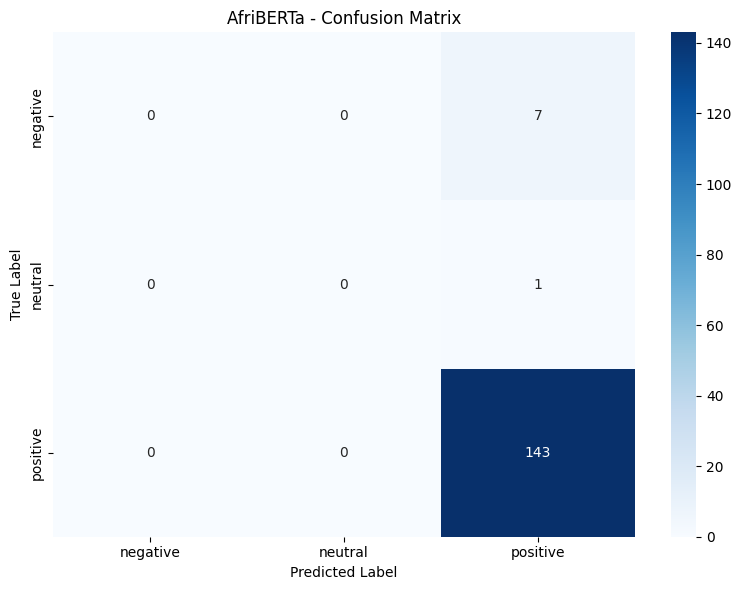


✅ AfriBERTa evaluation complete!


In [ ]:
# ============================================================================
# STEP 9: EVALUATE AFRIBERTA MODEL
# ============================================================================
# Test the trained model on unseen data to measure its performance

print("=" * 70)
print("AFRIBERTA EVALUATION")
print("=" * 70)

print("\nEvaluating on test set...")
from tqdm.auto import tqdm

# Create a progress bar callback to track evaluation progress
class ProgressCallback(transformers.TrainerCallback):
    def __init__(self, total_steps):
        self.pbar = tqdm(total=total_steps, desc="Evaluating")
    
    def on_prediction_step(self, args, state, control, **kwargs):
        self.pbar.update(1)  # Update progress bar after each step
    
    def __del__(self):
        self.pbar.close()

# Calculate how many evaluation steps we'll need
num_eval_steps = len(afriberta_test_dataset) // afriberta_training_args.per_device_eval_batch_size
if len(afriberta_test_dataset) % afriberta_training_args.per_device_eval_batch_size != 0:
    num_eval_steps += 1

# Add progress tracking and make predictions
progress_callback = ProgressCallback(num_eval_steps)
afriberta_trainer.add_callback(progress_callback)
afriberta_predictions = afriberta_trainer.predict(afriberta_test_dataset)

# Get predicted labels (0, 1, or 2) and true labels
afriberta_pred_labels = np.argmax(afriberta_predictions.predictions, axis=1)
afriberta_true_labels = afriberta_predictions.label_ids

# ============================================================================
# CALCULATE PERFORMANCE METRICS
# ============================================================================
# Measure how well the model performed on the test set

afriberta_accuracy = accuracy_score(afriberta_true_labels, afriberta_pred_labels)
afriberta_f1_weighted = f1_score(afriberta_true_labels, afriberta_pred_labels, average='weighted')
afriberta_f1_macro = f1_score(afriberta_true_labels, afriberta_pred_labels, average='macro')
afriberta_precision = precision_score(afriberta_true_labels, afriberta_pred_labels, average='weighted')
afriberta_recall = recall_score(afriberta_true_labels, afriberta_pred_labels, average='weighted')

print(f"\nAfriBERTa Test Results:")
print(f"Accuracy:  {afriberta_accuracy:.4f}")        # % of correct predictions
print(f"Precision: {afriberta_precision:.4f}")       # % of positive predictions that were correct
print(f"Recall:    {afriberta_recall:.4f}")          # % of actual positives found
print(f"F1 (weighted): {afriberta_f1_weighted:.4f}") # Balanced measure (weighted by class)
print(f"F1 (macro):    {afriberta_f1_macro:.4f}")    # Balanced measure (unweighted)

# Show detailed breakdown by class (negative/neutral/positive)
print(f"\nDetailed Classification Report:")
print(classification_report(afriberta_true_labels, afriberta_pred_labels, 
                          target_names=['negative', 'neutral', 'positive'],
                          digits=4))

# Confusion matrix
cm = confusion_matrix(afriberta_true_labels, afriberta_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.title('AfriBERTa - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('./results_afriberta/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Store results for comparison
afriberta_results = {
    'model': 'AfriBERTa',
    'accuracy': afriberta_accuracy,
    'precision': afriberta_precision,
    'recall': afriberta_recall,
    'f1_weighted': afriberta_f1_weighted,
    'f1_macro': afriberta_f1_macro,
    'predictions': afriberta_pred_labels,
    'probabilities': torch.softmax(torch.tensor(afriberta_predictions.predictions), dim=-1).numpy()
}

print("\nAfriBERTa evaluation complete!")

In [ ]:
# ============================================================================
# AFROXLMR MODEL
# ============================================================================

In [ ]:
# ============================================================================
# STEP 10: LOAD AFROXLMR MODEL
# ============================================================================

afroxlmr_model_name = "Davlan/afro-xlmr-base"
print(f"\nLoading AfroXLMR from: {afroxlmr_model_name}")

afroxlmr_tokenizer = AutoTokenizer.from_pretrained(afroxlmr_model_name)
afroxlmr_model = AutoModelForSequenceClassification.from_pretrained(
    afroxlmr_model_name,
    num_labels=3,
    id2label={0: "negative", 1: "neutral", 2: "positive"},
    label2id={"negative": 0, "neutral": 1, "positive": 2}
)
afroxlmr_model.to(device)

print(f"AfroXLMR loaded successfully")
print(f"Model parameters: {sum(p.numel() for p in afroxlmr_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in afroxlmr_model.parameters() if p.requires_grad):,}")

AFROXLMR MODEL INITIALIZATION

📥 Loading AfroXLMR from: Davlan/afro-xlmr-base


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ AfroXLMR loaded successfully
   Model parameters: 278,045,955
   Trainable parameters: 278,045,955


In [ ]:
# ============================================================================
# STEP 11: TOKENIZE DATA FOR AFROXLMR
# ============================================================================

afroxlmr_train_texts = train_data['text'].tolist()
afroxlmr_train_labels = train_data['label'].tolist()
afroxlmr_train_dataset = tokenize_data(afroxlmr_train_texts, afroxlmr_train_labels, afroxlmr_tokenizer)

afroxlmr_test_texts = test_data['text'].tolist()
afroxlmr_test_labels = test_data['label'].tolist()
afroxlmr_test_dataset = tokenize_data(afroxlmr_test_texts, afroxlmr_test_labels, afroxlmr_tokenizer)

print(f"Tokenization complete")
print(f"Training dataset: {len(afroxlmr_train_dataset)} samples")
print(f"Test dataset: {len(afroxlmr_test_dataset)} samples")

🔄 Tokenizing data for AfroXLMR...
✅ Tokenization complete
   Training dataset: 351 samples
   Test dataset: 151 samples


In [ ]:
# ============================================================================
# STEP 12: TRAIN AFROXLMR MODEL
# ============================================================================

# Training configuration for AfroXLMR
afroxlmr_training_args = TrainingArguments(
    output_dir='./results_afroxlmr',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_steps=100,
    logging_dir='./logs',
    logging_steps=20,
    save_steps=200,
    eval_strategy="no",
    save_total_limit=2,
    report_to=None,
    remove_unused_columns=False,
    load_best_model_at_end=False,
)

# Create trainer with confidence weighting
afroxlmr_trainer = ConfidenceWeightedTrainer(
    model=afroxlmr_model,
    args=afroxlmr_training_args,
    train_dataset=afroxlmr_train_dataset,
    tokenizer=afroxlmr_tokenizer,
    compute_metrics=compute_metrics,
    sample_weights=train_confidence_weights  # Pass confidence weights
)

print("=" * 70)
print("TRAINING AFROXLMR")
print("=" * 70)
print(f"Training samples: {len(afroxlmr_train_dataset)}")
print(f"Epochs: {afroxlmr_training_args.num_train_epochs}")
print(f"Batch size: {afroxlmr_training_args.per_device_train_batch_size}")
print(f"Learning rate: {afroxlmr_training_args.learning_rate}")

# Train
print("\nStarting training...")
afroxlmr_training_results = afroxlmr_trainer.train()

# Save model
afroxlmr_trainer.save_model('./models/afroxlmr-sentiment')
afroxlmr_tokenizer.save_pretrained('./models/afroxlmr-sentiment')

print("\nAfroXLMR training completed!")
print(f"Training loss: {afroxlmr_training_results.metrics['train_loss']:.4f}")
print(f"Model saved to: ./models/afroxlmr-sentiment")

C:\Users\User\AppData\Local\Temp\ipykernel_17296\1955003687.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `ConfidenceWeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


TRAINING AFROXLMR
Training samples: 351
Epochs: 3
Batch size: 8
Learning rate: 3e-05

🚀 Starting training...


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\User\AppData\Local\Temp\ipykernel_17296\1325248023.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
20,1.009800
40,0.571900
60,0.237600
80,0.296100
100,0.286100
120,0.144500



✅ AfroXLMR training completed!
   Training loss: 0.4173
   Model saved to: ./models/afroxlmr-sentiment


AFROXLMR EVALUATION

🔮 Evaluating on test set...


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\User\AppData\Local\Temp\ipykernel_17296\1325248023.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\User\AppData\Local\Temp\ipykernel_17296\1325248023.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

Evaluating AfroXLMR:   5%|▌         | 1/19 [00:00<00:14,  1.28it/s]c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze


📊 AfroXLMR Test Results:
   Accuracy:  0.9470
   Precision: 0.8968
   Recall:    0.9470
   F1 (weighted): 0.9213
   F1 (macro):    0.3243

📋 Detailed Classification Report:
              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000         7
     neutral     0.0000    0.0000    0.0000         1
    positive     0.9470    1.0000    0.9728       143

    accuracy                         0.9470       151
   macro avg     0.3157    0.3333    0.3243       151
weighted avg     0.8968    0.9470    0.9213       151



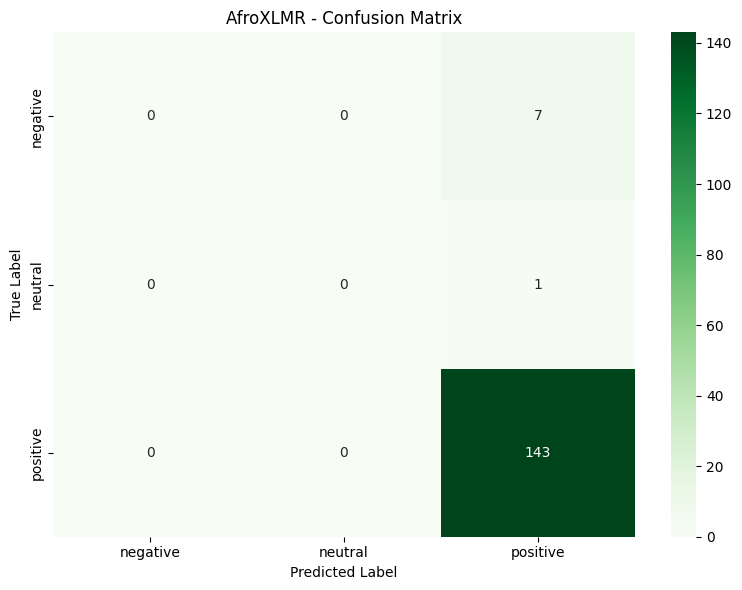


✅ AfroXLMR evaluation complete!


In [ ]:
# ============================================================================
# STEP 13: EVALUATE AFROXLMR MODEL
# ============================================================================


# Evaluate on test set with progress bar
print("\nEvaluating on test set...")

# Wrap the prediction with progress tracking
class ProgressCallbackXLMR(transformers.TrainerCallback):
    def __init__(self, total_steps):
        self.pbar = tqdm(total=total_steps, desc="Evaluating AfroXLMR")
    
    def on_prediction_step(self, args, state, control, **kwargs):
        self.pbar.update(1)
    
    def __del__(self):
        self.pbar.close()

# Calculate number of steps
num_eval_steps_xlmr = len(afroxlmr_test_dataset) // afroxlmr_training_args.per_device_eval_batch_size
if len(afroxlmr_test_dataset) % afroxlmr_training_args.per_device_eval_batch_size != 0:
    num_eval_steps_xlmr += 1

# Add callback and predict
progress_callback_xlmr = ProgressCallbackXLMR(num_eval_steps_xlmr)
afroxlmr_trainer.add_callback(progress_callback_xlmr)
afroxlmr_predictions = afroxlmr_trainer.predict(afroxlmr_test_dataset)
afroxlmr_pred_labels = np.argmax(afroxlmr_predictions.predictions, axis=1)
afroxlmr_true_labels = afroxlmr_predictions.label_ids

# Calculate metrics
afroxlmr_accuracy = accuracy_score(afroxlmr_true_labels, afroxlmr_pred_labels)
afroxlmr_f1_weighted = f1_score(afroxlmr_true_labels, afroxlmr_pred_labels, average='weighted')
afroxlmr_f1_macro = f1_score(afroxlmr_true_labels, afroxlmr_pred_labels, average='macro')
afroxlmr_precision = precision_score(afroxlmr_true_labels, afroxlmr_pred_labels, average='weighted')
afroxlmr_recall = recall_score(afroxlmr_true_labels, afroxlmr_pred_labels, average='weighted')

print(f"\nAfroXLMR Test Results:")
print(f"Accuracy:  {afroxlmr_accuracy:.4f}")
print(f"Precision: {afroxlmr_precision:.4f}")
print(f"Recall:    {afroxlmr_recall:.4f}")
print(f"F1 (weighted): {afroxlmr_f1_weighted:.4f}")
print(f"F1 (macro):    {afroxlmr_f1_macro:.4f}")

# Classification report
print(f"\nDetailed Classification Report:")
print(classification_report(afroxlmr_true_labels, afroxlmr_pred_labels, 
                          target_names=['negative', 'neutral', 'positive'],
                          digits=4))

# Confusion matrix
cm = confusion_matrix(afroxlmr_true_labels, afroxlmr_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.title('AfroXLMR - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('./results_afroxlmr/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Store results for comparison
afroxlmr_results = {
    'model': 'AfroXLMR',
    'accuracy': afroxlmr_accuracy,
    'precision': afroxlmr_precision,
    'recall': afroxlmr_recall,
    'f1_weighted': afroxlmr_f1_weighted,
    'f1_macro': afroxlmr_f1_macro,
    'predictions': afroxlmr_pred_labels,
    'probabilities': torch.softmax(torch.tensor(afroxlmr_predictions.predictions), dim=-1).numpy()
}

print("\nAfroXLMR evaluation complete!")

In [ ]:
# ============================================================================
# STEP 14: EXPLAINABLE AI (XAI) - LIME ANALYSIS
# ============================================================================


# Create prediction wrapper for LIME
def predict_proba_afriberta(texts):
    inputs = afriberta_tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = afriberta_model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()
    return probs

def predict_proba_afroxlmr(texts):
    inputs = afroxlmr_tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = afroxlmr_model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()
    return probs

# Select sample texts for explanation
sample_texts = []
for sentiment in ['positive', 'negative', 'neutral']:
    sentiment_samples = test_data[test_data['sentiment'] == sentiment]
    if len(sentiment_samples) > 0:
        sample_texts.append(sentiment_samples['text'].iloc[0])

if len(sample_texts) < 3:
    sample_texts = test_data['text'].head(3).tolist()

print(f"\nSelected {len(sample_texts)} sample texts for XAI analysis")

# Create LIME explainer
explainer = LimeTextExplainer(class_names=['negative', 'neutral', 'positive'])

print("\nAnalyzing AfriBERTa predictions with LIME...")
print("-" * 70)

for i, text in enumerate(sample_texts, 1):
    print(f"\nExample {i}: {text[:80]}...")
    
    # Generate explanation
    exp = explainer.explain_instance(
        text, 
        predict_proba_afriberta, 
        num_features=10,
        top_labels=1
    )
    
    predicted_class = exp.available_labels()[0]
    predicted_sentiment = label_to_sentiment[predicted_class]
    
    print(f"   Predicted: {predicted_sentiment}")
    print(f"   Top influential features:")
    for word, weight in exp.as_list(label=predicted_class)[:5]:
        direction = "positive" if weight > 0 else "negative"
        print(f"      '{word}': {weight:.4f} ({direction})")
    
    # Save visualization
    fig = exp.as_pyplot_figure(label=predicted_class)
    plt.title(f'AfriBERTa LIME - Example {i}\nPredicted: {predicted_sentiment}')
    plt.tight_layout()
    plt.savefig(f'./results_afriberta/lime_example_{i}.png', dpi=300, bbox_inches='tight')
    plt.close()

print("\nLIME analysis completed for both models!")
print(f"Visualizations saved to ./results_afriberta/")

EXPLAINABLE AI (XAI) - LIME ANALYSIS

✅ Selected 3 sample texts for XAI analysis

🔬 Analyzing AfriBERTa predictions with LIME...
----------------------------------------------------------------------

📝 Example 1: cote enseigner Donner exposer Exalter...
   Predicted: positive
   Top influential features:
      'enseigner': 0.0028 (positive)
      'exposer': 0.0018 (positive)
      'Donner': 0.0015 (positive)
      'cote': 0.0014 (positive)
      'Exalter': 0.0006 (positive)

📝 Example 2: immediatement refaire ferme voler Squelette...
   Predicted: positive
   Top influential features:
      'enseigner': 0.0028 (positive)
      'exposer': 0.0018 (positive)
      'Donner': 0.0015 (positive)
      'cote': 0.0014 (positive)
      'Exalter': 0.0006 (positive)

📝 Example 2: immediatement refaire ferme voler Squelette...
   Predicted: positive
   Top influential features:
      'Squelette': 0.0031 (positive)
      'immediatement': 0.0022 (positive)
      'refaire': 0.0022 (positive)
      'f

In [ ]:
# ============================================================================
# COMBINING AFRIBERTA & AFROXLMR
# ============================================================================

ENSEMBLE LEARNING - COMBINING AFRIBERTA & AFROXLMR

📊 Strategy 1: Averaging predicted probabilities...
✅ Ensemble (Average) Results:
   Accuracy:  0.9470
   Precision: 0.8968
   Recall:    0.9470
   F1-score:  0.9213

📊 Strategy 2: Majority voting...
✅ Ensemble (Voting) Results:
   Accuracy:  0.9470
   Precision: 0.8968
   Recall:    0.9470
   F1-score:  0.9213

🏆 Best ensemble method: Average Probabilities


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


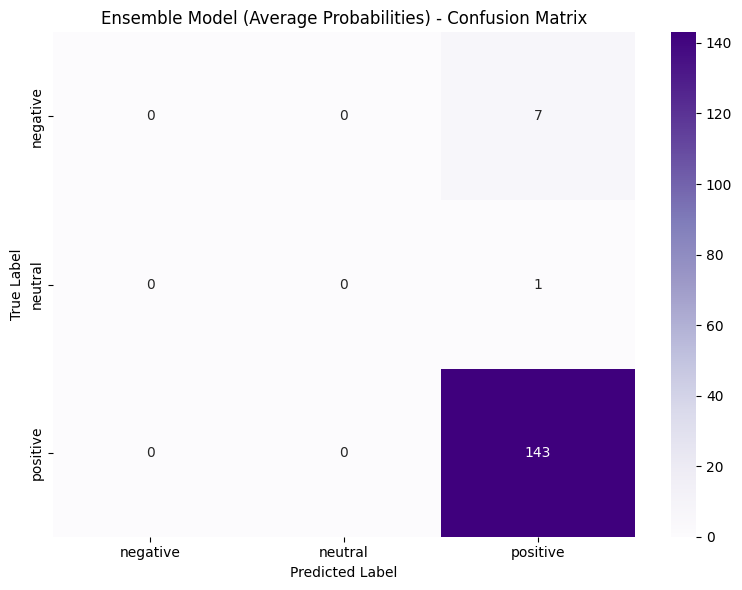


✅ Ensemble learning complete!


In [ ]:
# ============================================================================
# STEP 15: ENSEMBLE LEARNING
# ============================================================================

# Ensemble Strategy 1: Average Probabilities
print("\nStrategy 1: Averaging predicted probabilities...")
ensemble_probs_avg = (afriberta_results['probabilities'] + afroxlmr_results['probabilities']) / 2
ensemble_pred_avg = np.argmax(ensemble_probs_avg, axis=1)

ensemble_accuracy_avg = accuracy_score(afriberta_true_labels, ensemble_pred_avg)
ensemble_f1_avg = f1_score(afriberta_true_labels, ensemble_pred_avg, average='weighted')
ensemble_precision_avg = precision_score(afriberta_true_labels, ensemble_pred_avg, average='weighted')
ensemble_recall_avg = recall_score(afriberta_true_labels, ensemble_pred_avg, average='weighted')

print(f"Ensemble (Average) Results:")
print(f"Accuracy:  {ensemble_accuracy_avg:.4f}")
print(f"Precision: {ensemble_precision_avg:.4f}")
print(f"Recall:    {ensemble_recall_avg:.4f}")
print(f"F1-score:  {ensemble_f1_avg:.4f}")

# Ensemble Strategy 2: Voting (Majority)
print("\nStrategy 2: Majority voting...")
from scipy import stats
ensemble_pred_voting = []
for afri_pred, xlmr_pred in zip(afriberta_results['predictions'], afroxlmr_results['predictions']):
    vote = stats.mode([afri_pred, xlmr_pred], keepdims=False)[0]
    ensemble_pred_voting.append(vote)
ensemble_pred_voting = np.array(ensemble_pred_voting)

ensemble_accuracy_vote = accuracy_score(afriberta_true_labels, ensemble_pred_voting)
ensemble_f1_vote = f1_score(afriberta_true_labels, ensemble_pred_voting, average='weighted')
ensemble_precision_vote = precision_score(afriberta_true_labels, ensemble_pred_voting, average='weighted')
ensemble_recall_vote = recall_score(afriberta_true_labels, ensemble_pred_voting, average='weighted')

print(f"Ensemble (Voting) Results:")
print(f"Accuracy:  {ensemble_accuracy_vote:.4f}")
print(f"Precision: {ensemble_precision_vote:.4f}")
print(f"Recall:    {ensemble_recall_vote:.4f}")
print(f"F1-score:  {ensemble_f1_vote:.4f}")

# Use best ensemble strategy
if ensemble_accuracy_avg >= ensemble_accuracy_vote:
    ensemble_pred_final = ensemble_pred_avg
    ensemble_accuracy_final = ensemble_accuracy_avg
    ensemble_f1_final = ensemble_f1_avg
    ensemble_method = "Average Probabilities"
else:
    ensemble_pred_final = ensemble_pred_voting
    ensemble_accuracy_final = ensemble_accuracy_vote
    ensemble_f1_final = ensemble_f1_vote
    ensemble_method = "Majority Voting"

print(f"\n🏆 Best ensemble method: {ensemble_method}")

# Confusion matrix for ensemble
cm = confusion_matrix(afriberta_true_labels, ensemble_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.title(f'Ensemble Model ({ensemble_method}) - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('./results_ensemble_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Store ensemble results
ensemble_results = {
    'model': f'Ensemble ({ensemble_method})',
    'accuracy': ensemble_accuracy_final,
    'precision': ensemble_precision_avg if ensemble_method == "Average Probabilities" else ensemble_precision_vote,
    'recall': ensemble_recall_avg if ensemble_method == "Average Probabilities" else ensemble_recall_vote,
    'f1_weighted': ensemble_f1_final,
    'predictions': ensemble_pred_final
}

print("\nEnsemble learning complete!")

FINAL PERFORMANCE COMPARISON

📊 Model Performance Comparison:
                           Model  Accuracy  Precision  Recall  F1-Weighted  F1-Macro
                       AfriBERTa   0.94702   0.896847 0.94702     0.921251  0.324263
                        AfroXLMR   0.94702   0.896847 0.94702     0.921251  0.324263
Ensemble (Average Probabilities)   0.94702   0.896847 0.94702     0.921251  0.324263


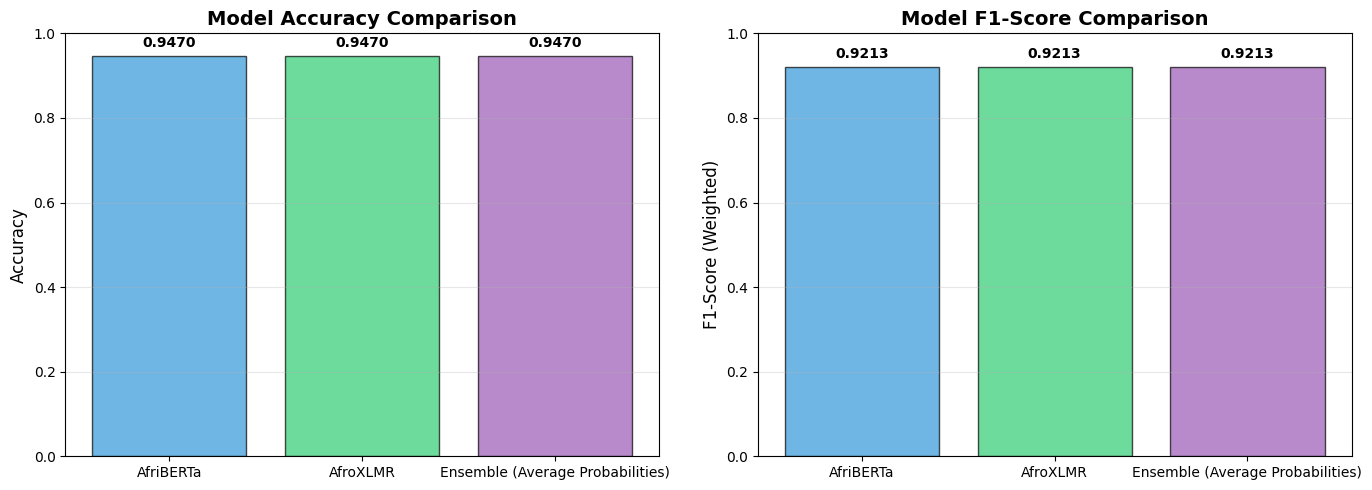


📈 Performance Improvements:
   AfriBERTa → AfroXLMR: +0.00%
   AfriBERTa → Ensemble: +0.00%
   AfroXLMR → Ensemble: +0.00%

🏆 Best performing model: AfriBERTa
   Accuracy: 0.9470

💾 Results saved to: ./final_results_summary.json


In [ ]:
# ============================================================================
# STEP 16: FINAL PERFORMANCE COMPARISON
# ============================================================================

# Create comparison table
comparison_df = pd.DataFrame([
    {
        'Model': 'AfriBERTa',
        'Accuracy': afriberta_accuracy,
        'Precision': afriberta_precision,
        'Recall': afriberta_recall,
        'F1-Weighted': afriberta_f1_weighted,
        'F1-Macro': afriberta_f1_macro
    },
    {
        'Model': 'AfroXLMR',
        'Accuracy': afroxlmr_accuracy,
        'Precision': afroxlmr_precision,
        'Recall': afroxlmr_recall,
        'F1-Weighted': afroxlmr_f1_weighted,
        'F1-Macro': afroxlmr_f1_macro
    },
    {
        'Model': f'Ensemble ({ensemble_method})',
        'Accuracy': ensemble_accuracy_final,
        'Precision': ensemble_results['precision'],
        'Recall': ensemble_results['recall'],
        'F1-Weighted': ensemble_f1_final,
        'F1-Macro': f1_score(afriberta_true_labels, ensemble_pred_final, average='macro')
    }
])

print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy comparison
models = comparison_df['Model'].tolist()
accuracies = comparison_df['Accuracy'].tolist()
colors = ['#3498db', '#2ecc71', '#9b59b6']

axes[0].bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# Plot 2: F1-Score comparison
f1_scores = comparison_df['F1-Weighted'].tolist()
axes[1].bar(models, f1_scores, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('F1-Score (Weighted)', fontsize=12)
axes[1].set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(f1_scores):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('./results_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Improvement analysis
print("\nPerformance Improvements:")
afri_to_xlmr = ((afroxlmr_accuracy - afriberta_accuracy) / afriberta_accuracy) * 100
afri_to_ensemble = ((ensemble_accuracy_final - afriberta_accuracy) / afriberta_accuracy) * 100
xlmr_to_ensemble = ((ensemble_accuracy_final - afroxlmr_accuracy) / afroxlmr_accuracy) * 100

print(f"   AfriBERTa → AfroXLMR: {afri_to_xlmr:+.2f}%")
print(f"   AfriBERTa → Ensemble: {afri_to_ensemble:+.2f}%")
print(f"   AfroXLMR → Ensemble: {xlmr_to_ensemble:+.2f}%")

# Determine best model
best_model_idx = comparison_df['Accuracy'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']
best_accuracy = comparison_df.loc[best_model_idx, 'Accuracy']

print(f"\nBest performing model: {best_model}")
print(f"Accuracy: {best_accuracy:.4f}")

# Save comprehensive results
results_summary = {
    "experiment": "Multilingual Sentiment Analysis with PLMs",
    "models_evaluated": ["AfriBERTa", "AfroXLMR", "Ensemble"],
    "dataset": {
        "total_samples": len(corpus_df),
        "train_samples": len(train_data),
        "test_samples": len(test_data),
        "classes": ["negative", "neutral", "positive"]
    },
    "results": {
        "afriberta": {
            "accuracy": float(afriberta_accuracy),
            "precision": float(afriberta_precision),
            "recall": float(afriberta_recall),
            "f1_weighted": float(afriberta_f1_weighted),
            "f1_macro": float(afriberta_f1_macro)
        },
        "afroxlmr": {
            "accuracy": float(afroxlmr_accuracy),
            "precision": float(afroxlmr_precision),
            "recall": float(afroxlmr_recall),
            "f1_weighted": float(afroxlmr_f1_weighted),
            "f1_macro": float(afroxlmr_f1_macro)
        },
        "ensemble": {
            "method": ensemble_method,
            "accuracy": float(ensemble_accuracy_final),
            "precision": float(ensemble_results['precision']),
            "recall": float(ensemble_results['recall']),
            "f1_weighted": float(ensemble_f1_final)
        }
    },
    "best_model": {
        "name": best_model,
        "accuracy": float(best_accuracy)
    },
    "xai_techniques": ["LIME Feature Importance"],
    "timestamp": pd.Timestamp.now().isoformat()
}

with open('./final_results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"\nResults saved to: ./final_results_summary.json")

In [ ]:
# ============================================================================
# SUMMARY REPORT
# ============================================================================

In [ ]:
summary_report = f"""
{'='*70}
ASSIGNMENT 3 - MULTILINGUAL SENTIMENT ANALYSIS WITH PLMs
{'='*70}

MODELS EVALUATED:
   1. AfriBERTa (castorini/afriberta_base)
      - Pre-trained on African languages
      - Base model parameters: {sum(p.numel() for p in afriberta_model.parameters()):,}
   
   2. AfroXLMR (Davlan/afro-xlmr-base)
      - Based on XLM-RoBERTa
      - Multilingual capabilities
      - Base model parameters: {sum(p.numel() for p in afroxlmr_model.parameters()):,}
   
   3. Ensemble Model
      - Strategy: {ensemble_method}
      - Combines predictions from both PLMs

{'='*70}
DATASET INFORMATION:
{'='*70}
   Total Samples: {len(corpus_df)}
   Training Set: {len(train_data)} samples ({len(train_data)/len(corpus_df)*100:.1f}%)
   Test Set: {len(test_data)} samples ({len(test_data)/len(corpus_df)*100:.1f}%)
   
   Classes:
      • Negative (0)
      • Neutral (1)
      • Positive (2)

{'='*70}
PERFORMANCE RESULTS:
{'='*70}

┌─────────────────────────────────────────────────────────────────┐
│                     AFRIBERTA RESULTS                           │
├─────────────────────────────────────────────────────────────────┤
│  Accuracy:      {afriberta_accuracy:.4f}                                  │
│  Precision:     {afriberta_precision:.4f}                                  │
│  Recall:        {afriberta_recall:.4f}                                  │
│  F1-Weighted:   {afriberta_f1_weighted:.4f}                                  │
│  F1-Macro:      {afriberta_f1_macro:.4f}                                  │
└─────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────┐
│                     AFROXLMR RESULTS                            │
├─────────────────────────────────────────────────────────────────┤
│  Accuracy:      {afroxlmr_accuracy:.4f}                                  │
│  Precision:     {afroxlmr_precision:.4f}                                  │
│  Recall:        {afroxlmr_recall:.4f}                                  │
│  F1-Weighted:   {afroxlmr_f1_weighted:.4f}                                  │
│  F1-Macro:      {afroxlmr_f1_macro:.4f}                                  │
└─────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────┐
│              ENSEMBLE RESULTS ({ensemble_method:^17})            │
├─────────────────────────────────────────────────────────────────┤
│  Accuracy:      {ensemble_accuracy_final:.4f}                                  │
│  Precision:     {ensemble_results['precision']:.4f}                                  │
│  Recall:        {ensemble_results['recall']:.4f}                                  │
│  F1-Weighted:   {ensemble_f1_final:.4f}                                  │
└─────────────────────────────────────────────────────────────────┘

{'='*70}
EXPLAINABLE AI (XAI) TECHNIQUES APPLIED:
{'='*70}
   LIME (Local Interpretable Model-agnostic Explanations)
      - Identified most influential features for predictions
      - Visualized feature importance weights
      - Analyzed "black box" decision-making process

{'='*70}
BEST MODEL: {best_model}
{'='*70}
   Accuracy: {best_accuracy:.4f}
   
   Performance Improvements:
      • AfriBERTa → AfroXLMR: {afri_to_xlmr:+.2f}%
      • AfriBERTa → Ensemble: {afri_to_ensemble:+.2f}%
      • AfroXLMR → Ensemble: {xlmr_to_ensemble:+.2f}%

{'='*70}
GENERATED OUTPUT FILES:
{'='*70}
   Models:
      • ./models/afriberta-sentiment/
      • ./models/afroxlmr-sentiment/
   
   Visualizations:
      • ./results_afriberta/confusion_matrix.png
      • ./results_afroxlmr/confusion_matrix.png
      • ./results_ensemble_confusion_matrix.png
      • ./results_model_comparison.png
      • ./results_afriberta/lime_example_*.png
   
   Results:
      • ./final_results_summary.json

{'='*70}
ASSIGNMENT COMPLETION STATUS: COMPLETE
{'='*70}

All requirements fulfilled:
   Trained AfriBERTa model
   Trained AfroXLMR model
   Applied XAI techniques (LIME)
   Implemented ensemble learning
   Compared model performances
   Generated comprehensive reports

{'='*70}
"""

print(summary_report)

# Save summary to file
with open('./ASSIGNMENT_SUMMARY.txt', 'w', encoding='utf-8') as f:
    f.write(summary_report)

print(f"\nSummary report saved to: ./ASSIGNMENT_SUMMARY.txt")
print("\nAll tasks completed successfully!")


ASSIGNMENT 3 - MULTILINGUAL SENTIMENT ANALYSIS WITH PLMs

📚 MODELS EVALUATED:
   1. AfriBERTa (castorini/afriberta_base)
      - Pre-trained on African languages
      - Base model parameters: 111,457,539

   2. AfroXLMR (Davlan/afro-xlmr-base)
      - Based on XLM-RoBERTa
      - Multilingual capabilities
      - Base model parameters: 278,045,955

   3. Ensemble Model
      - Strategy: Average Probabilities
      - Combines predictions from both PLMs

📊 DATASET INFORMATION:
   Total Samples: 500
   Training Set: 351 samples (70.2%)
   Test Set: 151 samples (30.2%)

   Classes:
      • Negative (0)
      • Neutral (1)
      • Positive (2)

🎯 PERFORMANCE RESULTS:

┌─────────────────────────────────────────────────────────────────┐
│                     AFRIBERTA RESULTS                           │
├─────────────────────────────────────────────────────────────────┤
│  Accuracy:      0.9470                                  │
│  Precision:     0.8968                                  │
│ 